In [8]:
%pip install pandas matplotlib seaborn numpy


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from datetime import datetime

In [10]:
# 1. Load and Combine Data
def load_and_combine_data():
    """Load and combine block and transaction data"""
    # Load transaction data
    tx_df = pd.read_parquet("../data/transactions.parquet")
    
    # Load block data
    block_df = pd.read_parquet("../data/blocks.parquet")
    
    # Convert hex values to numeric
    hex_columns = ['gas', 'gas_price', 'gas_used', 'max_priority_fee_per_gas', 
                  'max_fee_per_gas', 'effective_gas_price', 'cumulative_gas_used']
    for col in hex_columns:
        tx_df[col] = tx_df[col].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)
    
    block_hex_columns = ['base_fee_per_gas', 'gas_limit', 'gas_used', 'timestamp']
    for col in block_hex_columns:
        block_df[col] = block_df[col].apply(lambda x: int(x, 16) if isinstance(x, str) and x.startswith('0x') else x)
    
    # Merge block data with transactions
    combined_df = tx_df.merge(
        block_df,
        left_on='block_number',
        right_on='number',
        suffixes=('_tx', '_block')
    )
    
    return combined_df


In [11]:
# 2. Handle Missing Values
def handle_missing_values(df):
    """Handle missing values in the dataset"""
    df['max_priority_fee_per_gas'] = df['max_priority_fee_per_gas'].fillna(0)
    df['max_fee_per_gas'] = df['max_fee_per_gas'].fillna(0)
    df['effective_gas_price'] = df['effective_gas_price'].fillna(df['gas_price'])
    return df


In [12]:
# 3. Feature Engineering
def engineer_features(df):
    """Create features for analysis"""
    # Transaction-level features
    df['gas_utilization_ratio'] = df['gas_used_tx'] / df['gas']
    df['priority_fee_ratio'] = df['max_priority_fee_per_gas'] / (df['gas_price'] + 1e-10)
    df['fee_premium'] = df['gas_price'] - df['effective_gas_price']
    
    # Block-level features
    df['block_utilization'] = df['gas_used_block'] / df['gas_limit']
    df['base_fee_ratio'] = df['effective_gas_price'] / df['base_fee_per_gas']
    df['priority_fee_premium'] = df['max_priority_fee_per_gas'] - df['base_fee_per_gas']
    
    # Time-based features
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    # Rolling averages
    df['gas_price_last_5_avg'] = df.groupby('block_number')['gas_price'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )
    
    return df



In [19]:
# 4. Visualization Functions
def visualize_basic_metrics(df):
    """Basic gas price and block metrics visualization"""
    # Set the style using seaborn's set_theme
    sns.set_theme(style="whitegrid")
    
    # 1. Gas Price Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df['gas_price'], bins=50, alpha=0.7)
    plt.title('Gas Price Distribution')
    plt.xlabel('Gas Price (Wei)')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

    # 2. Block Utilization vs Gas Price
    plt.figure(figsize=(12, 6))
    plt.scatter(df['block_utilization'], df['effective_gas_price'], alpha=0.5, s=5)
    plt.title('Block Utilization vs Effective Gas Price')
    plt.xlabel('Block Utilization')
    plt.ylabel('Effective Gas Price (Wei)')
    plt.tight_layout()
    plt.show()

In [20]:
def visualize_time_patterns(df):
    """Temporal analysis visualization"""
    # 1. Hourly Gas Price Patterns
    plt.figure(figsize=(12, 6))
    hourly_fees = df.groupby('hour')['effective_gas_price'].mean()
    hourly_fees.plot(kind='bar')
    plt.title('Average Gas Price by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Gas Price')
    plt.show()

    # 2. Daily Pattern
    plt.figure(figsize=(12, 6))
    daily_fees = df.groupby('day_of_week')['effective_gas_price'].mean()
    daily_fees.plot(kind='bar')
    plt.title('Average Gas Price by Day of Week')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Gas Price')
    plt.show()

def visualize_fee_relationships(df):
    """Fee relationship visualization"""
    # 1. Base Fee vs Priority Fee Premium
    plt.figure(figsize=(12, 6))
    plt.scatter(df['base_fee_per_gas'], df['priority_fee_premium'], alpha=0.5, s=5)
    plt.title('Base Fee vs Priority Fee Premium')
    plt.xlabel('Base Fee')
    plt.ylabel('Priority Fee Premium')
    plt.show()

    # 2. Fee Components Correlation
    fee_components = ['base_fee_per_gas', 'max_priority_fee_per_gas', 
                     'effective_gas_price', 'gas_price']
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[fee_components].corr(), annot=True, cmap='coolwarm')
    plt.title('Fee Components Correlation')
    plt.show()



Loading and combining data...

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471618 entries, 0 to 13471617
Data columns (total 54 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   block_hash                object        
 1   block_number              uint64        
 2   from                      object        
 3   gas                       int64         
 4   gas_price                 int64         
 5   hash_tx                   object        
 6   input                     object        
 7   nonce_tx                  object        
 8   to                        object        
 9   transaction_index         uint64        
 10  value                     object        
 11  max_priority_fee_per_gas  float64       
 12  max_fee_per_gas           float64       
 13  chain_id                  object        
 14  cumulative_gas_used       int64         
 15  effective_gas_price       int64         
 16  gas

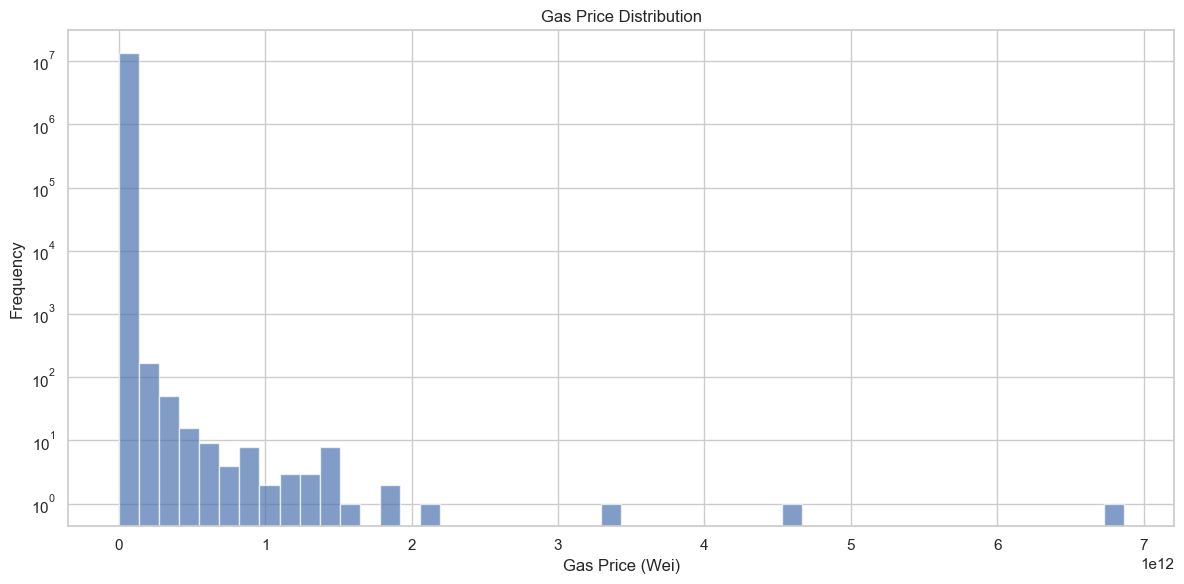

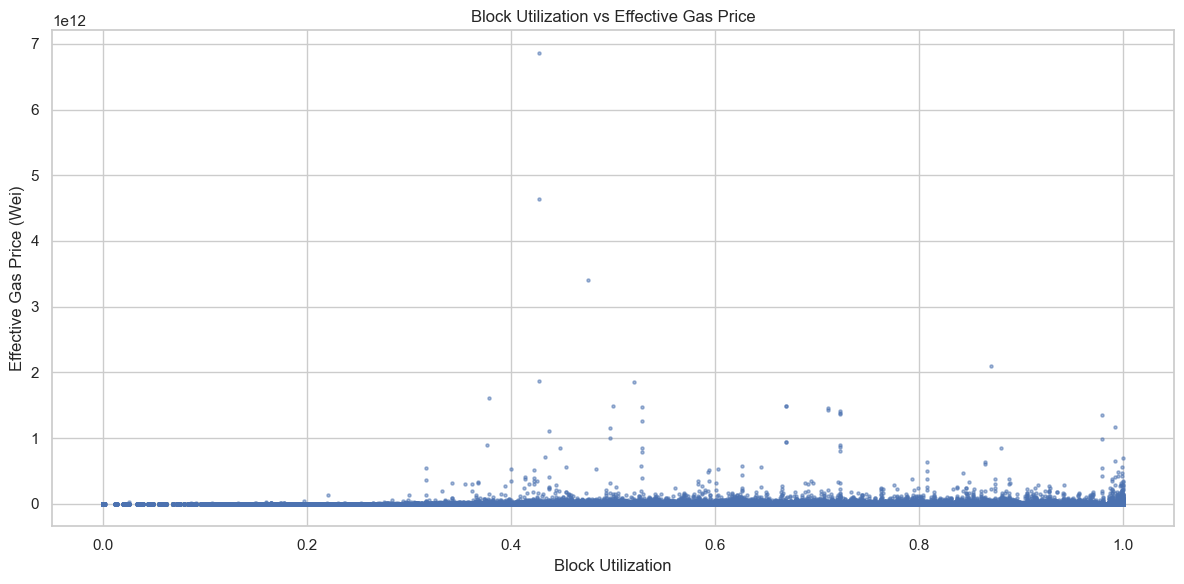

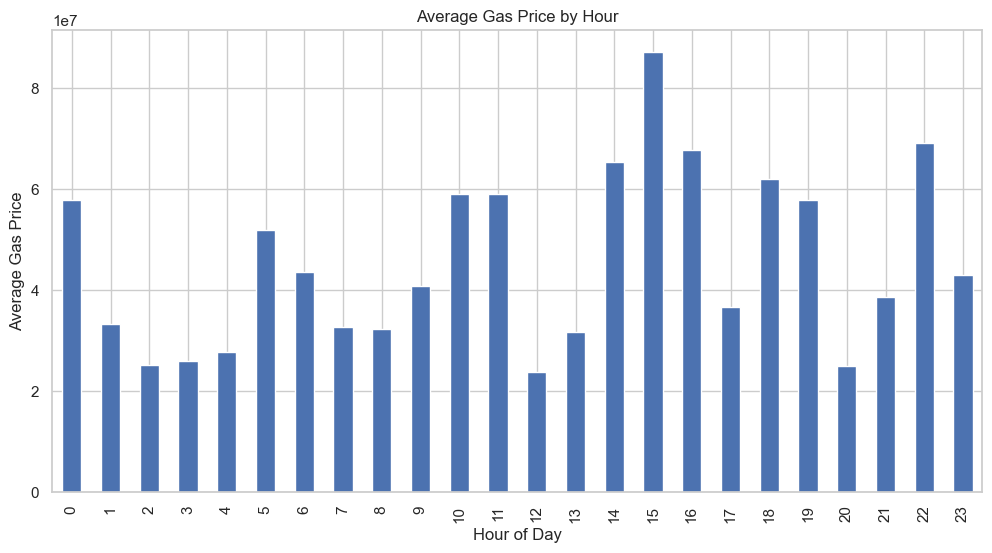

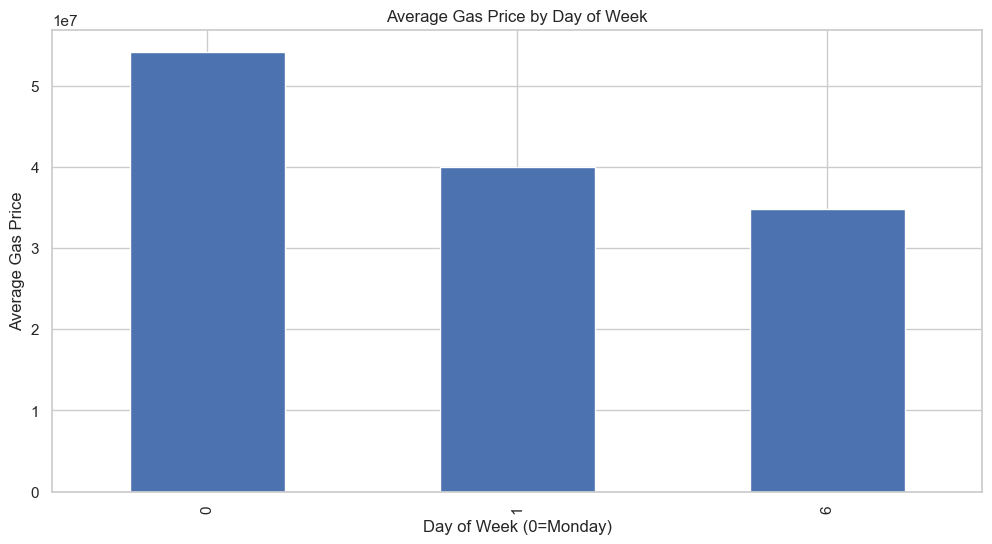

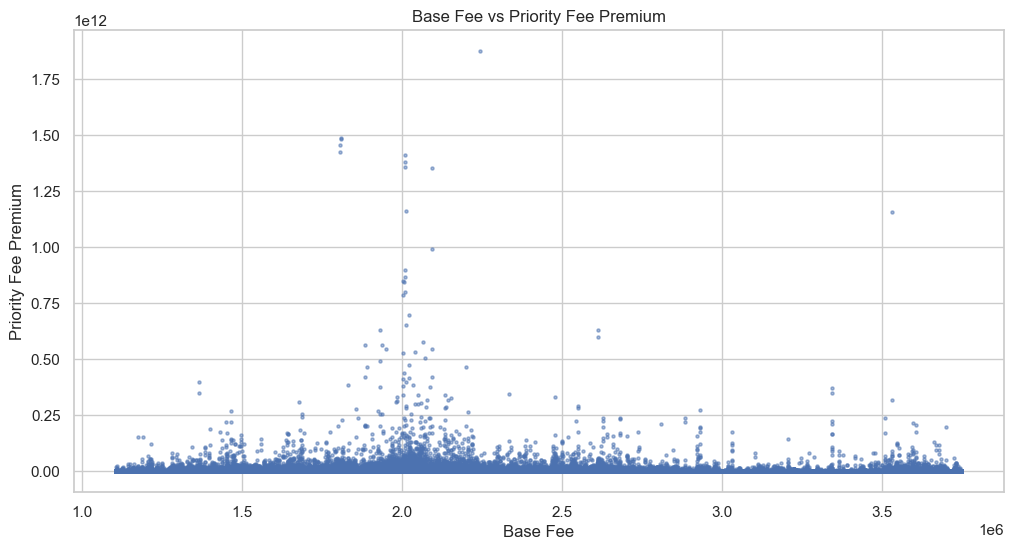

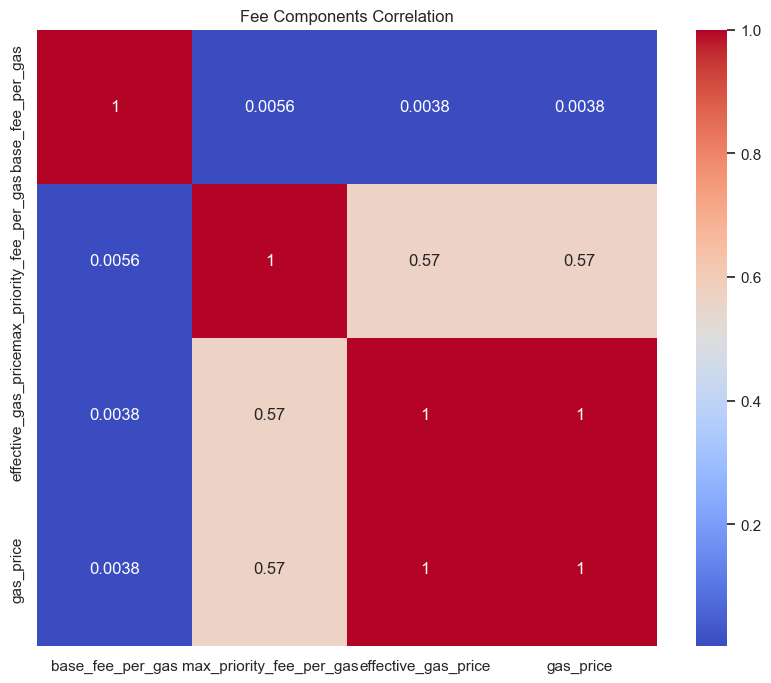

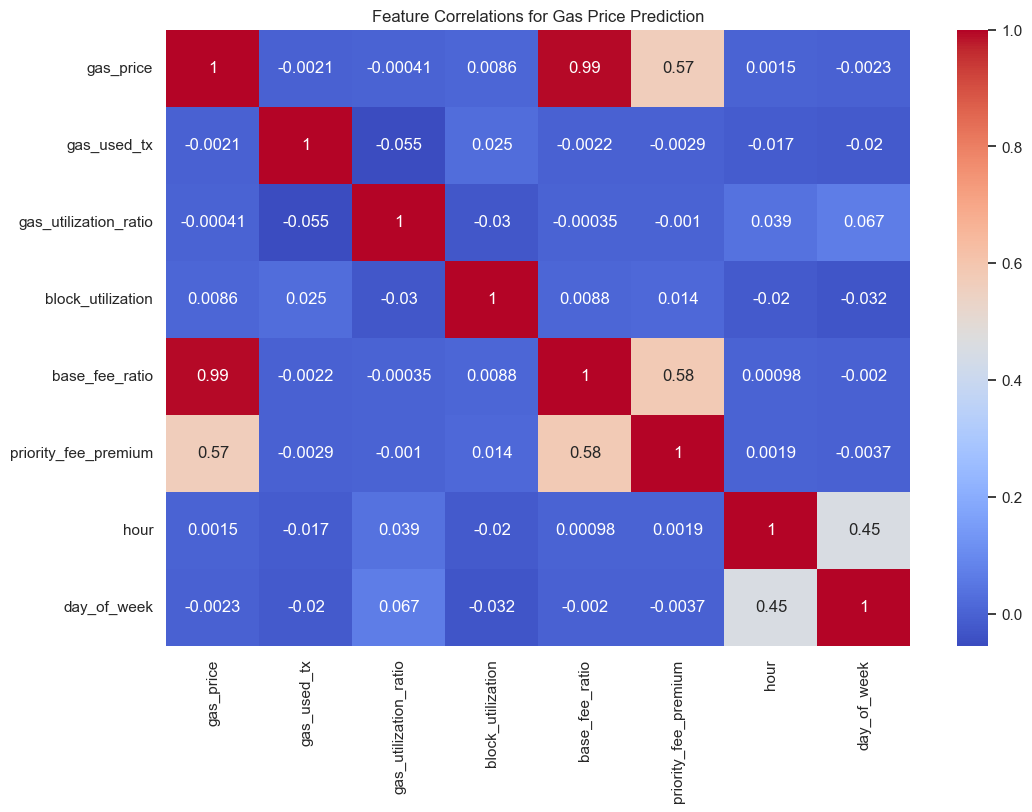

In [21]:
# 5. Main Analysis
def main():
    # Load and preprocess data
    print("Loading and combining data...")
    df = load_and_combine_data()
    
    df = handle_missing_values(df)
    df = engineer_features(df)
    
    # Display basic statistics
    print("\nDataset Overview:")
    print(df.info())
    
    print("\nSummary Statistics:")
    prediction_features = [
        'gas_price', 'gas_used_tx', 'gas_utilization_ratio',
        'block_utilization', 'base_fee_ratio', 'priority_fee_premium',
        'hour', 'day_of_week'
    ]
    print(df[prediction_features].describe())
    
    # Visualizations
    print("\nGenerating visualizations...")
    visualize_basic_metrics(df)
    visualize_time_patterns(df)
    visualize_fee_relationships(df)
    
    # Feature correlations
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[prediction_features].corr(), annot=True, cmap='coolwarm')
    plt.title('Feature Correlations for Gas Price Prediction')
    plt.show()
    
main()
